In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as tick
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

import xgboost

Let's dig in by loading the data and starting our Exploratory Data Analysis (EDA) by inspecting the first few rows, to get a feeling for what the data looks like

In [2]:
# define filepath to read data
dir_path = './Challenge_Data/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test.txt'), sep='\s+', header=None, names=col_names)

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [3]:
rul_limit = 922337203
df = train
grouped_by_unit = df.groupby(by="unit_nr")
max_cycle = grouped_by_unit["time_cycles"].max()

# Merge the max cycle back into the original frame
result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

# Calculate remaining useful life for each row
remaining_useful_life = pd.Series([np.min([rul_limit, i]) for i in (result_frame["max_cycle"] - result_frame["time_cycles"]).tolist()])

In [4]:
def add_remaining_useful_life(df, rul_limit = 922337203):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = pd.Series([np.min([rul_limit, i]) for i in (result_frame["max_cycle"] - result_frame["time_cycles"]).tolist()])    
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train, 130)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,130
1,1,2,130
2,1,3,130
3,1,4,130
4,1,5,130


## Cluster-wise Standardization

In [5]:
from sklearn.preprocessing import StandardScaler
def create_clusters(df):
    model = pickle.load(open("kmeans_op.pkl", "rb"))
    preds = model.predict(df[['setting_1', 'setting_2', 'setting_3']])
    tmp = df.copy()
    tmp["OP"] = pd.Series(preds)
    tmp = tmp.drop(['setting_1', 'setting_2', 'setting_3'], axis=1)
    return tmp

def create_scalers(df): #should probably just give train split here
    scaling_columns = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
    scalers = []
    for i in range(6):
        scaler = StandardScaler()
        scaler.fit(df[df["OP"] == i][scaling_columns])
        scalers.append(scaler)
    
    return scalers

In [6]:
from sklearn.model_selection import GroupShuffleSplit
# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, gss, groups, print_groups=True):
    y = X.pop('RUL')
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split
train = create_clusters(train)
split_result = train_val_group_split(train, gss, train['unit_nr'])
X_train, y_train, X_val, y_val = split_result

train_split_engines [  1   2   3   4   5   6   7   8   9  11  12  13  14  15  18  20  21  22
  23  24  25  27  28  29  30  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62
  63  64  65  66  69  70  71  72  73  75  77  78  79  81  82  83  84  85
  86  87  88  89  90  91  92  93  95  96  98  99 100 102 103 104 105 106
 107 108 111 112 113 115 116 117 118 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 138 139 142 143 145 146 147 149 150 151 152
 154 157 158 159 160 161 162 164 165 166 167 168 169 170 172 173 175 176
 180 181 182 183 184 185 187 188 189 191 192 194 196 197 198 199 200 201
 202 203 205 206 207 209 210 211 213 215 217 218] 

validate_split_engines [ 10  16  17  19  26  31  46  56  67  68  74  76  80  94  97 101 109 110
 114 119 120 137 140 141 144 148 153 155 156 163 171 174 177 178 179 186
 190 193 195 204 208 212 214 216] 



In [7]:
scalers = create_scalers(X_train)

In [8]:
def scale(df, scalers):
    scaling_columns = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
    new_x = []
    for i in range(len(scalers)):
        k = scalers[i].transform(df[df['OP'] == i][scaling_columns])
        new_x.extend(k)
        
    return new_x

In [9]:
X_train = scale(X_train, scalers)
X_val = scale(X_val, scalers)

In [10]:
scaling_columns = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
X_train = pd.DataFrame(X_train, columns = scaling_columns)
X_val = pd.DataFrame(X_val, columns = scaling_columns)

## Competition Score

In [11]:
import math
from sklearn.metrics import make_scorer
def phm_Score(y_true, y_pred):
    score = 0
    for t, p in zip(y_true, y_pred):
        if p >= t:
            score+= math.exp(-(p-t)/13) - 1
        else:
            score+= math.exp(-(p-t)/10) - 1
    return score/len(y_true)
my_scorer = make_scorer(phm_Score, greater_is_better=False)

## XGBoost Regression - baseline

In [12]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='Test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [13]:
# create an xgboost regression model
xgb_reg = xgboost.XGBRegressor(tree_method = "gpu_hist", predictor = "gpu_predictor", n_jobs = 4, verbosity = 1, n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# evaluate model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [14]:
y_hat = xgb_reg.predict(X_val)
y_train_pred = xgb_reg.predict(X_train)
evaluate(y_train, y_train_pred, label = "Train")
evaluate(y_val, y_hat)

Train set RMSE:14.262043215197318, R2:0.8920525427568611
Test set RMSE:46.239244704354235, R2:-0.13979151052867933


# Fine tuning

In [18]:
xgb_clf = xgboost.XGBRegressor(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 1,
                           objective = "reg:squarederror")
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = my_scorer,
                             cv = 5, verbose = 3, random_state = 42, n_jobs = 6, n_iter=50)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 250 out of 250 | elapsed: 27.8min finished


In [19]:
xgb_rscv.best_score_

-26.24195551649286

In [14]:
xgb_rscv.best_score_

-1650.5777052147805

In [20]:
# Model best estimators
lr = model_xgboost.best_estimator_.get_params()["learning_rate"]
gam = model_xgboost.best_estimator_.get_params() ["gamma"]
m_dep = model_xgboost.best_estimator_.get_params()["max_depth"]
sub_smp = model_xgboost.best_estimator_.get_params()["subsample"]
col_smp = model_xgboost.best_estimator_.get_params()["colsample_bytree"]
alp = model_xgboost.best_estimator_.get_params()["reg_alpha"]
lamb = model_xgboost.best_estimator_.get_params()["reg_lambda"]
m_chld_w = model_xgboost.best_estimator_.get_params()["min_child_weight"]
n_est = model_xgboost.best_estimator_.get_params()["n_estimators"]
print("Learning Rate: ", lr)
print("Gamma: ", gam)
print("Max Depth: ", m_dep)
print("Subsample: ", sub_smp)
print("Max Features at Split: ", col_smp)
print("Alpha: ", alp)
print("Lamda: ", lamb)
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ", m_chld_w)
print("Number of Trees: ", n_est)

Learning Rate:  0.01
Gamma:  0.3
Max Depth:  2
Subsample:  0.4
Max Features at Split:  0.8
Alpha:  1
Lamda:  4.5
Minimum Sum of the Instance Weight Hessian to Make a Child:  3
Number of Trees:  1000


## Now we train with new params

In [21]:
# create an xgboost regression model
xgb_reg = xgboost.XGBRegressor(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 2, 
                               n_estimators=n_est, max_depth=m_dep, subsample=sub_smp, colsample_bytree=col_smp,
                               learning_rate = lr, reg_alpha = alp, reg_lambda = lamb, min_child_weight = m_chld_w)
# evaluate model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=0, reg_alpha=1,
             reg_lambda=4.5, scale_pos_weight=1, subsample=0.4,
             tree_method='gpu_hist', validate_parameters=1, verbosity=2)

In [22]:
y_hat = xgb_reg.predict(X_val)
y_train_pred = xgb_reg.predict(X_train)
evaluate(y_train, y_train_pred, label = "Train")
evaluate(y_val, y_hat)

Train set RMSE:43.079820110967816, R2:0.015089691655897464
Test set RMSE:43.40700496342376, R2:-0.004439069360764547


In [30]:
y_val.to_list()

[130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 130,
 129,
 128,
 127,
 126,
 125,
 124,
 123,
 122,
 121,
 120,
 119,
 118,
 117,
 116,
 115,
 114,
 113,
 112,
 111,
 110,
 109,
 108,
 107,
 106,
 105,
 104,
 103,
 102,
 101,
 100,
 99,
 98,
 97,
 96,
 95,
 94,
 93,
 92,
 91,
 90,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 5

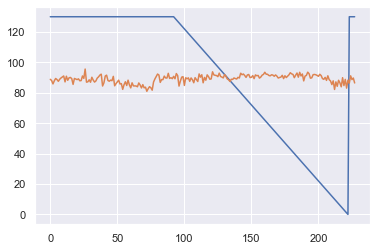

In [35]:
plt.plot(y_train.to_list()[:228])
plt.plot(y_train_pred[:228])

Got better poj

# Make submission

In [23]:
def testpreproc(df, scalers):
    df = create_clusters(df)
    df = scale(df, scalers)
    scaling_columns = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
    df = pd.DataFrame(df, columns = scaling_columns)
    return df

In [24]:
pred = xgb_reg.predict(testpreproc(test, scalers))

In [25]:
with open("sub__01.txt", 'w') as output:
    for row in pred:
        output.write(str(row) + '\n')